In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import nltk
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, GlobalMaxPooling1D, LSTM, Dropout, Embedding, Bidirectional

from datasets import load_dataset

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AADESH\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\AADESH\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\AADESH\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
cache_dir = "./data_cache"

train_dataset = load_dataset(
    "tweet_eval",
    name="emotion",
    split="train",
    cache_dir=cache_dir,
)
print(f"Training dataset with {len(train_dataset)} instances loaded")


val_dataset = load_dataset(
    "tweet_eval",
    name="emotion",
    split="validation",
    cache_dir=cache_dir,
)
print(f"Development/validation dataset with {len(val_dataset)} instances loaded")


test_dataset = load_dataset(
    "tweet_eval",
    name="emotion",
    split="test",
    cache_dir=cache_dir,
)
print(f"Test dataset with {len(test_dataset)} instances loaded")

# Access the input text and target labels like this...
train_texts = train_dataset['text']
train_labels = train_dataset['label']

val_texts = val_dataset['text']
val_labels = val_dataset['label']

test_texts = test_dataset['text']
test_labels = test_dataset['label']

Training dataset with 3257 instances loaded
Development/validation dataset with 374 instances loaded
Test dataset with 1421 instances loaded


In [3]:
#using hugging face reference for label to sentiment
sentiment2label = {0: 'ANGER', 1: 'JOY', 2: 'OPTIMISM', 3: 'SADNESS'}
for i in range(7):
    print(f"TEXT[{i}]: {train_texts[i]}")  # Accessing train_texts and not train_dataset
    print(f"LABEL[{i}]: {sentiment2label[train_labels[i]]}")  # Accessing train_labels directly
    print()

TEXT[0]: “Worry is a down payment on a problem you may never have'.  Joyce Meyer.  #motivation #leadership #worry
LABEL[0]: OPTIMISM

TEXT[1]: My roommate: it's okay that we can't spell because we have autocorrect. #terrible #firstworldprobs
LABEL[1]: ANGER

TEXT[2]: No but that's so cute. Atsu was probably shy about photos before but cherry helped her out uwu
LABEL[2]: JOY

TEXT[3]: Rooneys fucking untouchable isn't he? Been fucking dreadful again, depay has looked decent(ish)tonight
LABEL[3]: ANGER

TEXT[4]: it's pretty depressing when u hit pan on ur favourite highlighter
LABEL[4]: SADNESS

TEXT[5]: @user but your pussy was weak from what I heard so stfu up to me bitch . You got to threaten him that your pregnant .
LABEL[5]: ANGER

TEXT[6]: Making that yearly transition from excited and hopeful college returner to sick and exhausted pessimist. #college
LABEL[6]: SADNESS



# EDA

In [4]:
import re
# Cleaning text data
def clean_text(text):
    lemmatiser = WordNetLemmatizer()
    # Remove URLs
    cleaned_text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Remove user mentions
    cleaned_text = re.sub(r'@\w+', '', cleaned_text)
    # Remove non-alphanumeric characters and numbers
    cleaned_text = re.sub(r'\W+|\d+', ' ', cleaned_text)
    # Remove single characters
    cleaned_text = re.sub(r'\s+[a-zA-Z]\s+', ' ', cleaned_text)
    # Tokenize and remove stop words
    stop_words = set(stopwords.words('english'))
    text_tokens = nltk.word_tokenize(cleaned_text)
    cleaned_text = ' '.join([lemmatiser.lemmatize(word.lower()) for word in text_tokens if word.lower() not in stop_words])
    # Remove extra whitespace
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    return cleaned_text

# Clean the text data for each sample
cleaned_train_texts = [clean_text(text) for text in train_texts]

# Print cleaned text and corresponding labels
for i in range(7):
    print(f"TEXT[{i}]: {cleaned_train_texts[i]}")
    print(f"LABEL[{i}]: {sentiment2label[train_labels[i]]}")
    print()

TEXT[0]: worry payment problem may never joyce meyer motivation leadership worry
LABEL[0]: OPTIMISM

TEXT[1]: roommate okay spell autocorrect terrible firstworldprobs
LABEL[1]: ANGER

TEXT[2]: cute atsu probably shy photo cherry helped uwu
LABEL[2]: JOY

TEXT[3]: rooneys fucking untouchable fucking dreadful depay looked decent ish tonight
LABEL[3]: ANGER

TEXT[4]: pretty depressing hit pan ur favourite highlighter
LABEL[4]: SADNESS

TEXT[5]: pussy weak heard stfu bitch got threaten pregnant
LABEL[5]: ANGER

TEXT[6]: making yearly transition excited hopeful college returner sick exhausted pessimist college
LABEL[6]: SADNESS



In [5]:
# Clean the validation text data for each sample
cleaned_val_texts = [clean_text(text) for text in val_texts]

# Print cleaned validation text and corresponding labels
for i in range(5):
    print(f"TEXT[{i}]: {cleaned_val_texts[i]}")
    print(f"LABEL[{i}]: {sentiment2label[val_labels[i]]}")
    print()

TEXT[0]: oh hidden revenge anger rememberthe time rebutted
LABEL[0]: ANGER

TEXT[1]: teamchristine bc tana done provoke tweeting shady shit trying hard bitch begging fight
LABEL[1]: ANGER

TEXT[2]: hey field skibbereen give online delivery service horrible name hour late hour delivery window
LABEL[2]: ANGER

TEXT[3]: emmerdale rob robron first child together vile woman cheating sl smh bitter
LABEL[3]: ANGER

TEXT[4]: would like hear podcast going refuting entire article extra indignation please
LABEL[4]: ANGER



In [6]:
# Clean the validation text data for each sample
cleaned_test_texts = [clean_text(text) for text in test_texts]

# Print cleaned test text and corresponding labels
for i in range(5):
    print(f"TEXT[{i}]: {cleaned_test_texts[i]}")
    print(f"LABEL[{i}]: {sentiment2label[test_labels[i]]}")
    print()

TEXT[0]: deppression real partner depressed people truly dont understand depth affect u add anxiety amp make worse
LABEL[0]: SADNESS

TEXT[1]: interesting choice word confirming government fund terrorism bit open door still
LABEL[1]: ANGER

TEXT[2]: visit hospital care triggered trauma accident yr ago image dead brother feeling symptom depression
LABEL[2]: SADNESS

TEXT[3]: welcome mpsvt delighted grateful mpsvt relationship
LABEL[3]: JOY

TEXT[4]: make feel joyful
LABEL[4]: JOY



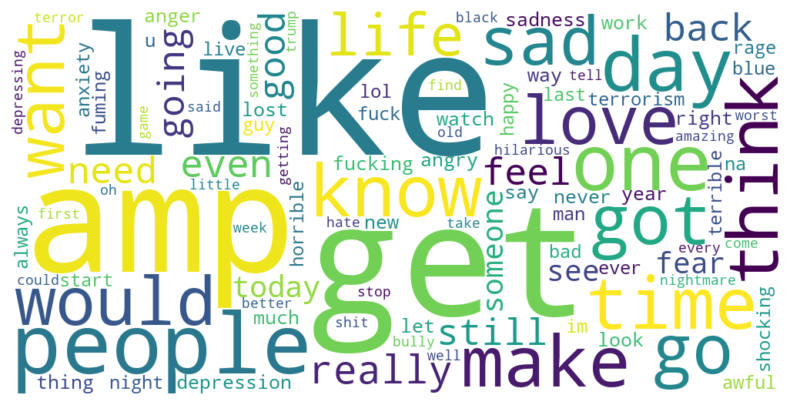

In [7]:
from nltk.probability import FreqDist
tokens = [token for text in cleaned_train_texts for token in text.split()]
frequency_distribution=FreqDist(tokens)
most_common_words = frequency_distribution.most_common(100)

# Generate a word cloud
word_freq = dict(most_common_words)  # Convert list of tuples to dictionary
wordcloud = WordCloud(width=1000, height=500, background_color ='white').generate_from_frequencies(word_freq)

# Plotting the Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Non Neural

In [8]:
#encoding labels using label encoder
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
val_labels = label_encoder.fit_transform(val_labels)
test_labels = label_encoder.fit_transform(test_labels)

In [9]:
#vectorising using bag of words
vectoriser = CountVectorizer(max_features=7000)
X_train = vectoriser.fit_transform(cleaned_train_texts)
X_val = vectoriser.transform(cleaned_val_texts)
X_test = vectoriser.transform(cleaned_test_texts)

In [10]:
# using TF-IDF alternatively for comparision
tfidf_vectorizer = TfidfVectorizer(max_features=7000)
X_train_tfidf = tfidf_vectorizer.fit_transform(cleaned_train_texts)
X_val_tfidf = tfidf_vectorizer.transform(cleaned_val_texts)
X_test_tfidf = tfidf_vectorizer.transform(cleaned_test_texts)

In [11]:
#training the classifier with bag of words
from sklearn.svm import SVC
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train, train_labels)

SVC(kernel='linear')

In [12]:
# Train the SVM classifier with TF-IDF features
svm_classifier_tfidf = SVC(kernel='linear')
svm_classifier_tfidf.fit(X_train_tfidf, train_labels)

SVC(kernel='linear')

In [13]:
#evaluating the classifier for bag of words
train_pred= svm_classifier.predict(X_train)
val_pred = svm_classifier.predict(X_val)
test_pred = svm_classifier.predict(X_test)

In [15]:
print(classification_report(train_labels, train_pred, target_names = ['ANGER','JOY','OPTIMISM','SADNESS']))
print(classification_report(val_labels, val_pred, target_names = ['ANGER','JOY','OPTIMISM','SADNESS']))
print(classification_report(test_labels, test_pred, target_names = ['ANGER','JOY','OPTIMISM','SADNESS']))

              precision    recall  f1-score   support

       ANGER       0.98      0.99      0.99      1400
         JOY       0.99      0.99      0.99       708
    OPTIMISM       1.00      0.96      0.98       294
     SADNESS       0.98      0.98      0.98       855

    accuracy                           0.99      3257
   macro avg       0.99      0.98      0.99      3257
weighted avg       0.99      0.99      0.99      3257

              precision    recall  f1-score   support

       ANGER       0.69      0.74      0.71       160
         JOY       0.64      0.48      0.55        97
    OPTIMISM       0.27      0.29      0.28        28
     SADNESS       0.51      0.56      0.53        89

    accuracy                           0.60       374
   macro avg       0.52      0.52      0.52       374
weighted avg       0.60      0.60      0.59       374

              precision    recall  f1-score   support

       ANGER       0.68      0.76      0.72       558
         JOY       0.

In [16]:
#evaluating the classifier for TF-IDF
train_pred_tfidf = svm_classifier_tfidf.predict(X_train)
val_pred_tfidf = svm_classifier_tfidf.predict(X_val)
test_pred_tfidf = svm_classifier_tfidf.predict(X_test)

In [17]:
# Train the SVM classifier with TF-IDF features
svm_classifier_tfidf = SVC(kernel='linear')
svm_classifier_tfidf.fit(X_train_tfidf, train_labels)

SVC(kernel='linear')

In [18]:
print(classification_report(train_labels, train_pred_tfidf, target_names = ['ANGER','JOY','OPTIMISM','SADNESS']))
print(classification_report(val_labels, val_pred_tfidf, target_names = ['ANGER','JOY','OPTIMISM','SADNESS']))
print(classification_report(test_labels, test_pred_tfidf, target_names = ['ANGER','JOY','OPTIMISM','SADNESS']))

              precision    recall  f1-score   support

       ANGER       0.95      0.97      0.96      1400
         JOY       0.95      0.94      0.94       708
    OPTIMISM       0.96      0.89      0.92       294
     SADNESS       0.93      0.93      0.93       855

    accuracy                           0.95      3257
   macro avg       0.95      0.93      0.94      3257
weighted avg       0.95      0.95      0.95      3257

              precision    recall  f1-score   support

       ANGER       0.72      0.68      0.70       160
         JOY       0.66      0.53      0.59        97
    OPTIMISM       0.27      0.46      0.34        28
     SADNESS       0.52      0.57      0.55        89

    accuracy                           0.60       374
   macro avg       0.54      0.56      0.54       374
weighted avg       0.62      0.60      0.61       374

              precision    recall  f1-score   support

       ANGER       0.69      0.72      0.71       558
         JOY       0.

# NEURAL

In [19]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
import evaluate

# Loading the tokenizer
checkpoint = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint, use_fast=True)

def tokenise_texts(texts):
    return tokenizer(texts, padding=True, truncation=True)

In [20]:
# Tokenising each text
train_encodings = tokenise_texts(train_texts)
val_encodings = tokenise_texts(val_texts)
test_encodings = tokenise_texts(test_texts)

In [21]:
# Convert to Hugging Face datasets
from datasets import Dataset
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': train_labels
})
val_dataset = Dataset.from_dict({
    'input_ids': val_encodings['input_ids'],
    'attention_mask': val_encodings['attention_mask'],
    'labels': val_labels
})
test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': test_labels
})

In [22]:
# Metrics for evaluation
accuracy_metric = evaluate.load('accuracy')
f1_metric = evaluate.load('f1')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=preds, references=labels)
    f1 = f1_metric.compute(predictions=preds, references=labels, average='macro')
    return {**accuracy, **f1}

In [28]:
# Setup the model
num_labels = 4  # ANGER, JOY, OPTIMISM, SADNESS
id2label = {0: 'ANGER', 1: 'JOY', 2: 'OPTIMISM', 3:'SADNESS'}
label2id = {v: k for k, v in id2label.items()}

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels, id2label=id2label, label2id=label2id)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    report_to="none",
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [30]:
# Train the model
trainer.train()

# Extract metrics for visualization
train_results = trainer.evaluate(train_dataset)
val_results = trainer.evaluate(val_dataset)

train_accuracy = train_results["eval_accuracy"]
val_accuracy = val_results["eval_accuracy"]

train_f1 = train_results["eval_f1"]
val_f1 = val_results["eval_f1"]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.666963,0.762032,0.660370
2,No log,0.613910,0.764706,0.711070
3,0.661000,0.602628,0.791444,0.741531


In [31]:
# Evaluate the model on the test set
test_results = trainer.evaluate(test_dataset)
print(test_results)

test_accuracy = test_results["eval_accuracy"]

test_f1 = test_results["eval_f1"]

{'eval_loss': 0.5602095723152161, 'eval_accuracy': 0.7987332864180154, 'eval_f1': 0.7463811586199876, 'eval_runtime': 167.3198, 'eval_samples_per_second': 8.493, 'eval_steps_per_second': 0.532, 'epoch': 3.0}


In [32]:
#extracting loss from training
train_loss = trainer.state.log_history
training_history = {'train_loss':[],'eval_loss':[]}
for log in train_loss:
    if 'loss' in train_loss:
        training_history['train_loss'].append(log['loss'])
    if 'eval_loss' in log.keys():
        training_history['eval_loss'].append(log['eval_loss'])

#fill in eval_loss where it is missing to match the length of train_loss
max_length = max(len(training_history['train_loss']), len(training_history['eval_loss']))
if not training_history['train_loss']:
    training_history['train_loss'].append(0)
if not training_history['eval_loss']:
    training_history['eval_loss'].append(0)
    
while len(training_history['train_loss']) < max_length:
    training_history['train_loss'].append(training_history['train_loss'][-1])
while len(training_history['eval_loss']) < max_length:
    training_history['eval_loss'].append(training_history['eval_loss'][-1])

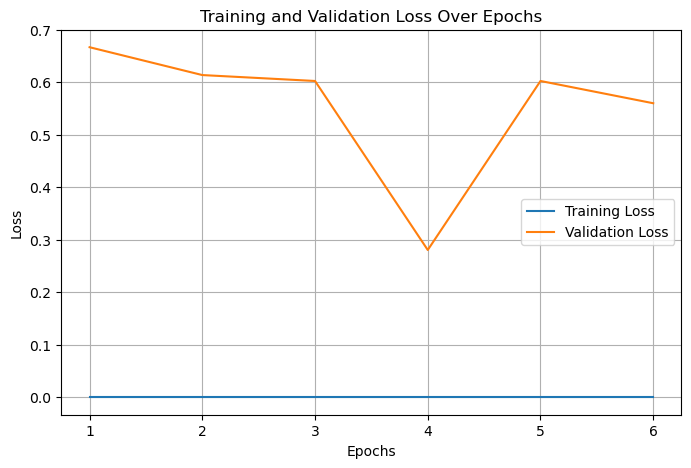

In [33]:
# plotting the loss
def learning_curves(training_history):
    epochs = range(1, len(training_history['train_loss']) + 1)
    plt.figure(figsize=(8, 5))
    # Plot training and validation loss
    plt.plot(epochs, training_history['train_loss'], label='Training Loss')
    plt.plot(epochs, training_history['eval_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()
    
learning_curves(training_history)

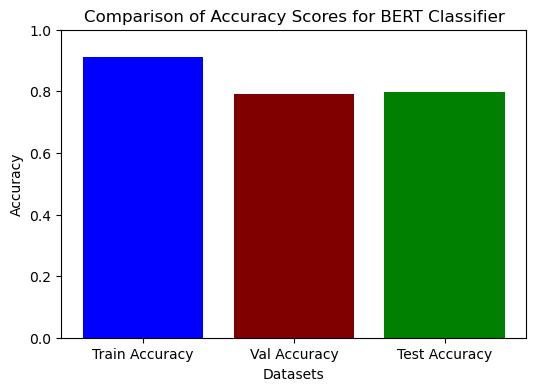

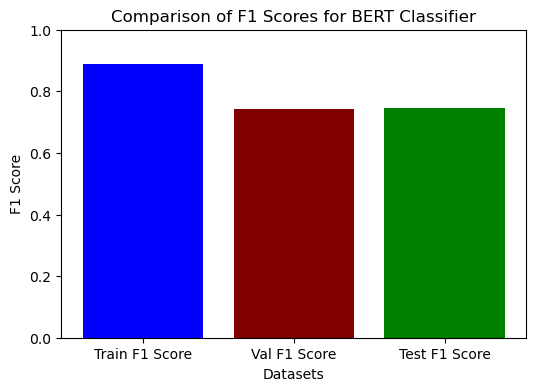

In [34]:
# Visualize the comparison for accuracy
metrics = ["Train Accuracy", "Val Accuracy", "Test Accuracy"]
accuracy_scores = [train_accuracy, val_accuracy, test_accuracy]

plt.figure(figsize=(6, 4))
plt.bar(metrics, accuracy_scores, color=["blue", "maroon", "green"])
plt.xlabel("Datasets")
plt.ylabel("Accuracy")
plt.title("Comparison of Accuracy Scores for BERT Classifier")
plt.ylim(0, 1)
plt.show()

# Visualize the comparison for F1 score
f1_metrics = ["Train F1 Score", "Val F1 Score", "Test F1 Score"]
f1_scores = [train_f1, val_f1, test_f1]

plt.figure(figsize=(6, 4))
plt.bar(f1_metrics, f1_scores, color=["blue", "maroon", "green"])
plt.xlabel("Datasets")
plt.ylabel("F1 Score")
plt.title("Comparison of F1 Scores for BERT Classifier")
plt.ylim(0, 1)
plt.show()